# **`Project 3: Team John Hicks`**

## **Mali** File

### **Objective**: Compare the nutritional intake and food intake in Uganda vs. the US before, during, and after the pandemic.

#### Group Members:
> Leona Katibah <br>
> Jack Pollard <br>
> Jakob Mackanych <br>
> Xi Wang <br>
> Wendy Peng <br>
> Sury Dongre
test


# Project Setup

In [96]:
#import all packages here
#%%capture install_log
!pip install -r requirements.txt

In [97]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [98]:
uganda_data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
#uganda_data = '1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ'


# **[A] Choice of a Population -  with supporting expenditure data**

- **Population chosen:** Households in **Mali** and in USA - but this document focuses only on the Mali data to maintain clarity across datasets.

- **Time periods:** Using data from **2014–15** (pre-COVID) and **2021–22** (post-COVID)
- **Reason for choice:** To explore how the COVID-19 pandemic impacted *food demand and consumption patterns*
- **Data available:** Detailed household-level data on *food expenditures, prices, and demographics*



# **[B] Nutritional content of differnet foods**

### Select a **Year** (2013–14 or 2019–20) and clean DFs

In [99]:
import cfe

# Define your InputFiles dictionary.

# --------------------------------------------
# CHANGE YEAR - down and to right - (2013-14 or 2019-20) and Run Cell
#---------------------------------------------

InputFiles = {
    'Expenditures': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2013-14)'), #CHANGE YEAR HERE 2013-14 OR 2019-20
    'Prices': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
    'HH Characteristics': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
    'FCT': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
    'RDI': ('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),
}



def get_clean_sheet(key, sheet=None):
    """
    Read a sheet from Google Sheets, clean column names and duplicates.
    """
    df = read_sheets(key, sheet=sheet)
    # Strip whitespace from column names.
    df.columns = [c.strip() for c in df.columns.tolist()]
    # Remove duplicate columns, keeping the first occurrence.
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    # Drop columns that start with 'Unnamed'
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    # Drop duplicate rows based on the index.
    df = df.loc[~df.index.duplicated(), :]
    # Also drop any completely duplicate rows.
    df = df.drop_duplicates()
    return df


def load_data(InputFiles):
    """
    Load and preprocess the Expenditures, HH Characteristics, Prices, FCT, and RDI data.
    Returns:
      x: Expenditures DataFrame indexed by ['i','t','m'] with columns 'j'
      z: Household characteristics DataFrame indexed by ['i','t','m']
      p, fct, rdi: Other data sets (if needed for later analysis)
    """
    # Get expenditures
    x = get_clean_sheet(InputFiles['Expenditures'][0],
                        sheet=InputFiles['Expenditures'][1])
    if 'm' not in x.columns:
        x['m'] = 1
    x = x.set_index(['i','t','m'])
    x.columns.name = 'j'
    x = x.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    x = x.replace(0, np.nan)
    
    # Get HH Characteristics
    z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                        sheet=InputFiles['HH Characteristics'][1])
    if 'm' not in z.columns:
        z['m'] = 1
    z = z.set_index(['i','t','m'])
    z.columns.name = 'k'
    z = z.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get Prices (if needed later)
    p = get_clean_sheet(InputFiles['Prices'][0],
                        sheet=InputFiles['Prices'][1])
    if 'm' not in p.columns:
        p['m'] = 1
    p = p.set_index(['t','m'])
    p.columns.name = 'j'
    p = p.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    p = p.replace(0, np.nan)
    
    # Get FCT
    fct = get_clean_sheet(InputFiles['FCT'][0],
                          sheet=InputFiles['FCT'][1])
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    fct = fct.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    
    # Get RDI
    rdi = get_clean_sheet(InputFiles['RDI'][0],
                          sheet=InputFiles['RDI'][1])
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    
    return x, z, p, fct, rdi


def prepare_expenditures_for_regression(x):
    """
    Convert the Expenditures DataFrame to a 1D Series (y) for regression.
    This function aggregates duplicate (i,t,m,j) combinations using the mean,
    then takes the natural log.
    """
    # Stack the expenditures so that columns (j) become part of the index.
    # Reset index to make all index levels into columns.
    df_long = x.stack().reset_index(name='expenditure')
    # Now, if duplicates exist in (i,t,m,j), aggregate them.
    df_agg = df_long.groupby(['i', 't', 'm', 'j'])['expenditure'].mean().reset_index()
    # Set the multi-index again.
    y = df_agg.set_index(['i', 't', 'm', 'j'])['expenditure']
    # Take the log of expenditures.
    y_log = np.log(y)
    return y_log


def run_regression(x, z):
    """
    Prepare the data and run the regression of log(expenditures) on household characteristics.
    Returns the regression result from cfe.
    """
    # Prepare y (dependent variable)
    y_log = prepare_expenditures_for_regression(x)
    
    # Run the regression.
    result = cfe.Regression(y=y_log, d=z)
    return result


# =============================================================================
# Example of using the functions:
# =============================================================================

# Load all data.
x, z, p, fct, rdi = load_data(InputFiles)

# Optionally, you can check a preview of your data:
display(x.head())
display(z.head())
display(p.head())
display(fct.head())
display(rdi.head())

print("Shape of x (Expenditures):", x.shape)
print("Shape of z (HH Characteristics):", z.shape)
print("Shape of p (Prices):", p.shape)
print("Shape of fct (Food Composition Table):", fct.shape)
print("Shape of rdi (Recommended Daily Intake):", rdi.shape)

# Run the regression.
result = run_regression(x, z)

# Display sorted regression coefficients.
beta_sorted = result.get_beta().sort_values(ascending=False)
print(beta_sorted.head(20))


,,j,Beans,Beef,Beer,Biscuits,Bongo,Bread,"Butter, etc.",Cabbages,Cake,Cassava,...,Sugarcane,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi,Water,Wheat (flour),Yam,Yogurt
i,t,m,,,,,,,,,,,,,,,,,,,,,
1013000201,2013-14,Central,1500.0,NaN,NaN,NaN,NaN,1600.0,NaN,NaN,NaN,4000.0,...,NaN,NaN,10000.0,NaN,1400.0,NaN,NaN,NaN,NaN,NaN
1013000202,2013-14,Central,5000.0,NaN,NaN,NaN,NaN,250.0,NaN,NaN,NaN,2000.0,...,NaN,NaN,6000.0,150.0,900.0,NaN,NaN,NaN,NaN,NaN
1013000204,2013-14,Central,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,4000.0,...,NaN,NaN,5000.0,200.0,1400.0,NaN,NaN,NaN,NaN,NaN
1021000108,2013-14,Central,6400.0,7000.0,NaN,NaN,NaN,3600.0,NaN,NaN,NaN,3000.0,...,NaN,NaN,2000.0,500.0,2000.0,NaN,NaN,NaN,NaN,NaN
1021000109,2013-14,Central,3000.0,9000.0,NaN,NaN,NaN,1800.0,NaN,1000.0,NaN,NaN,...,NaN,NaN,2000.0,200.0,2000.0,NaN,NaN,NaN,NaN,NaN


k                                                 F 00-03  F 04-08  F 09-13  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              1.0      0.0      1.0   
                                 2019-20 Eastern      1.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      1.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              0.0      1.0      1.0   

k                                                 F 14-18  F 19-30  F 31-50  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              3.0      1.0      0.0   
                                 2019-20 Eastern      3.0      1.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      1.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      0.0      1.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              0.0      0.0      1.0   

k                                                 F 51+  M 00-03  M 04-08  \
i                                t       m                                  
00c9353d8ebe42faabf5919b81d7fae7 2018-19            1.0      0.0      0.0   
                                 2019-20 Eastern    1.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19            0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19            0.0      0.0      2.0   
039a11571b874a88b7a6c200469fe4f3 2018-19            0.0      0.0      0.0   

k                                                 M 09-13  M 14-18  M 19-30  \
i                                t       m                                    
00c9353d8ebe42faabf5919b81d7fae7 2018-19              1.0      0.0      0.0   
                                 2019-20 Eastern      1.0      0.0      0.0   
02dd448165ce46279ca601a02865d543 2018-19              0.0      0.0      0.0   
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0      0.0      0.0   
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0      0.0      0.0   

k                                                 M 31-50  M 51+  log HSize  
i                                t       m                                   
00c9353d8ebe42faabf5919b81d7fae7 2018-19              0.0    0.0   2.079442  
                                 2019-20 Eastern      0.0    0.0   1.945910  
02dd448165ce46279ca601a02865d543 2018-19              0.0    0.0   0.000000  
037866653c7c4cb99a80f05a38cdafb2 2018-19              0.0    1.0   1.609438  
039a11571b874a88b7a6c200469fe4f3 2018-19              1.0    0.0   1.609438

j                       Beans  Beef    Beer  Biscuits  Bongo   Bread  \
t       m                                                              
2005-06 Central    650.000000  2500  3000.0       NaN    NaN  1400.0   
2005-6  Eastern    550.000000  2400  2000.0       NaN    NaN  1000.0   
        Northern   434.151414  2500  2400.0       NaN    NaN  1000.0   
        Western    500.000000  2200  2500.0       NaN    NaN  1000.0   
2009-10 Central   1350.000000  5000  4000.0       NaN    NaN  2400.0   

j                 Butter, etc.  Cabbages  Cake  Cassava  ...  Sugarcane  \
t       m                                                ...              
2005-06 Central         3000.0    1400.0   NaN    500.0  ...        NaN   
2005-6  Eastern         3300.0    1050.0   NaN    500.0  ...        NaN   
        Northern        1500.0    1225.0   NaN    300.0  ...        NaN   
        Western         3000.0    1050.0   NaN    500.0  ...        NaN   
2009-10 Central         4800.0    1750.0   NaN   1000.0  ...        NaN   

j                 Sweet Bananas  Sweet Potatoes     Tea  Tomatoes  Waragi  \
t       m                                                                   
2005-06 Central       54.054054           750.0   800.0     100.0     NaN   
2005-6  Eastern       40.000000           200.0   800.0     100.0     NaN   
        Northern      43.243243           200.0   800.0     100.0     NaN   
        Western       41.621622           200.0  1000.0     200.0     NaN   
2009-10 Central      108.108108          1000.0   800.0     300.0     NaN   

j                 Water  Wheat (flour)  Yam  Yogurt  
t       m                                            
2005-06 Central     NaN            NaN  NaN     NaN  
2005-6  Eastern     NaN            NaN  NaN     NaN  
        Northern    NaN            NaN  NaN     NaN  
        Western     NaN            NaN  NaN     NaN  
2009-10 Central     NaN            NaN  NaN     NaN  

[5 rows x 74 columns]

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


Shape of x (Expenditures): (3082, 74)
Shape of z (HH Characteristics): (24363, 15)
Shape of p (Prices): (32, 74)
Shape of fct (Food Composition Table): (103, 15)
Shape of rdi (Recommended Daily Intake): (20, 14)
j
Bread             0.858047
Passion Fruits    0.831891
Oranges           0.805432
Sweet Bananas     0.798603
Other Fruits      0.782316
Milk (fresh)      0.743656
Tomatoes          0.626547
Mangos            0.618517
Other Veg.        0.618228
Dodo              0.609728
Eggs              0.600786
Cooking Oil       0.592344
Cabbages          0.568183
Soda              0.559312
Fish (fresh)      0.559244
Rice              0.558823
Chapati           0.554303
Beer              0.553969
Fish (dried)      0.549289
Onions            0.531736
Name: beta, dtype: float64


In [100]:
result.to_pickle('./foo.pickle')

In [101]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [102]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          76803.370386
Protein          1765.858494
Fiber            1235.925542
Folate          14818.038498
Calcium         16081.534560
Carbohydrate    12665.399558
Iron              486.244238
Niacin            547.805519
Riboflavin         50.015242
Thiamin            64.114162
Vitamin A       13188.538539
Vitamin B-12       79.510471
Vitamin B-6       110.949084
Vitamin C       11239.374116
Zinc              260.243606
dtype: float64

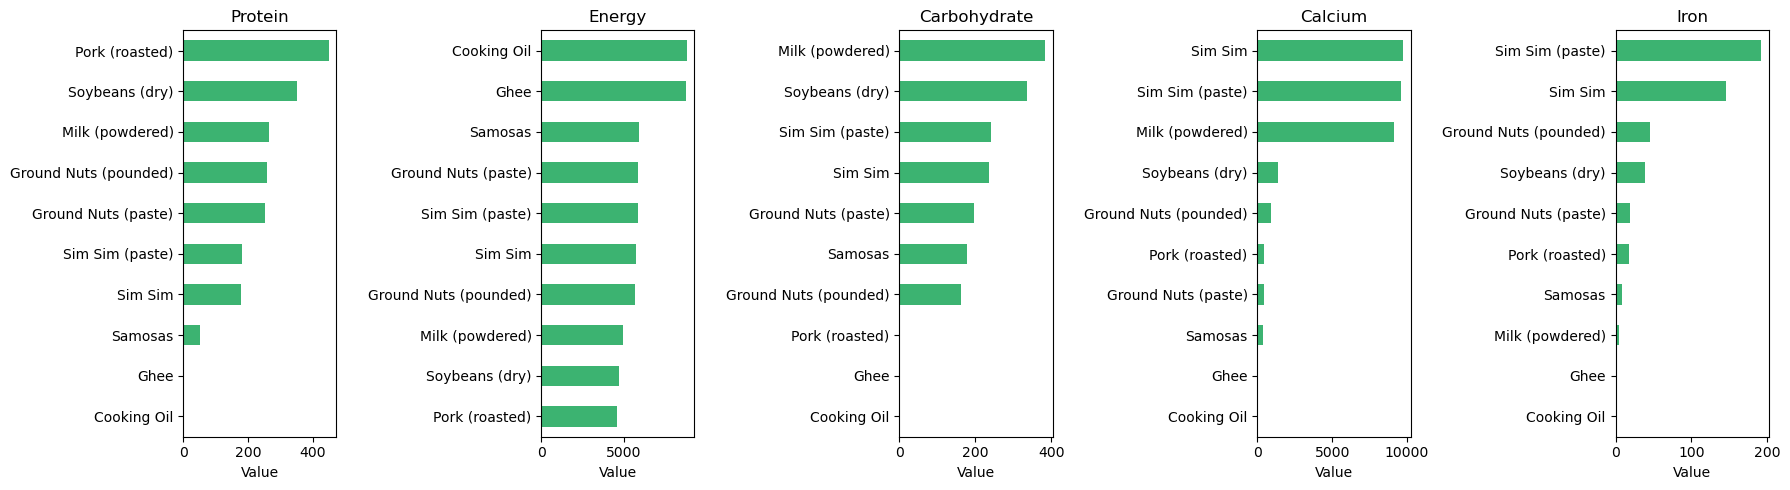

In [103]:
import matplotlib.pyplot as plt

# Select your nutrients
selected_nutrients = ["Protein", "Energy", "Carbohydrate", "Calcium", "Iron"]
fct_subset = fct[selected_nutrients]

# Get the top 10 foods by Energy as reference (you could also use Protein or average)
top_foods = fct_subset["Energy"].sort_values(ascending=False).head(10).index
fct_top = fct_subset.loc[top_foods]

# Plot bar charts
fig, axes = plt.subplots(nrows=1, ncols=len(fct_top.columns), figsize=(18, 5))

for ax, nutrient in zip(axes, fct_top.columns):
    fct_top[nutrient].sort_values().plot.barh(ax=ax, color='mediumseagreen')
    ax.set_title(nutrient)
    ax.set_xlabel("Value")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


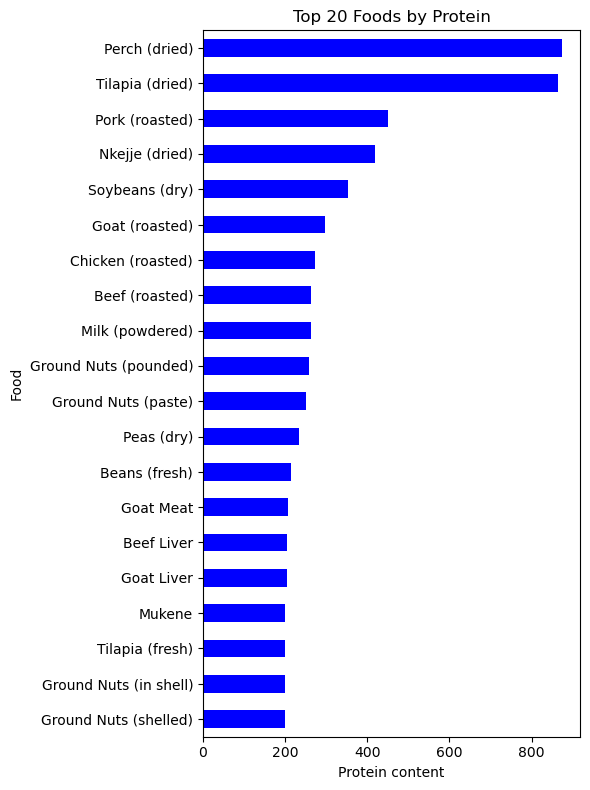

In [104]:

fct_sub = fct[selected_nutrients]

import matplotlib.pyplot as plt

# Suppose fct_sub is a DataFrame of shape (num_foods, num_nutrients).
# Pick a single nutrient, e.g., "Protein".
nutrient = "Protein"

# Sort foods by descending nutrient content
fct_sorted = fct_sub[nutrient].dropna().sort_values(ascending=False)

# Possibly select top 20
fct_top20 = fct_sorted.head(20)

# Horizontal bar plot
plt.figure(figsize=(6, 8))
fct_top20.plot.barh(color="blue")
plt.gca().invert_yaxis()  # highest at top
plt.title(f"Top 20 Foods by {nutrient}")
plt.xlabel(f"{nutrient} content")
plt.ylabel("Food")
plt.tight_layout()
plt.show()



#  **[B] Nutritional adequacy of diet** 

In [105]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

In [106]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
1013000201,2013-14,Central,1.612648,1.670197,1.484842,1.384532,0.613376,3.231330,1.557799,1.444594,1.923978,2.019441,0.733845,1.953373,2.801374,3.912751,1.108172
1013000202,2013-14,Central,0.905674,1.025570,0.803910,0.768386,0.226145,1.507097,0.752274,0.820826,0.973349,1.266778,0.354653,0.934209,1.850177,3.297914,0.676264
1013000204,2013-14,Central,1.099638,1.211417,1.024702,0.941723,0.316584,1.739299,0.928828,1.002541,1.188701,1.508783,0.442922,1.155591,2.136379,3.582485,0.811379
1021000108,2013-14,Central,1.128220,1.186449,1.022988,1.011349,0.445306,2.281432,1.348818,1.052675,1.393424,1.531544,0.484669,1.384231,1.843211,2.487340,0.826284
1021000109,2013-14,Central,0.718448,0.741230,0.626940,0.586190,0.225735,1.396346,0.576105,0.640883,0.783217,0.962681,0.284918,0.791778,1.362546,1.954367,0.516830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H43006-04-01,2013-14,Western,1.147396,1.626815,1.457552,1.461402,0.440164,2.271403,1.372402,1.394018,1.814565,1.864307,0.758690,1.556891,3.207891,5.916950,1.047026
H43007-04-01,2013-14,Western,0.743001,0.812899,0.850733,0.809034,0.293596,1.927212,0.937857,0.843773,0.871309,1.301611,0.307800,0.742259,2.062055,2.946568,0.645451
H43008-04-01,2013-14,Western,0.737997,0.801833,0.832901,0.772463,0.197781,1.581952,0.706491,0.796312,0.743602,1.337978,0.253801,0.549004,2.320072,4.182568,0.631279


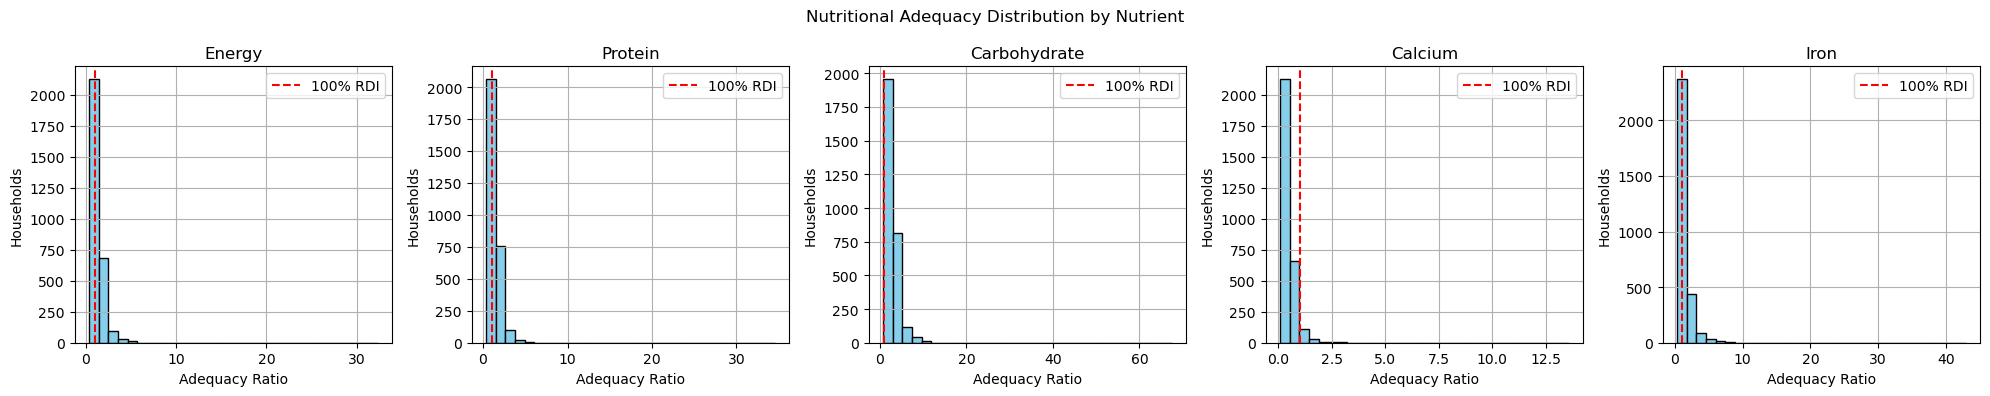

In [107]:
import matplotlib.pyplot as plt

nutrients_to_plot = ['Energy', 'Protein', 'Carbohydrate', 'Calcium', 'Iron']

fig, axes = plt.subplots(nrows=1, ncols=len(nutrients_to_plot), figsize=(20, 4))

for ax, nutrient in zip(axes, nutrients_to_plot):
    nutrient_ratio[nutrient].hist(ax=ax, bins=30, color='skyblue', edgecolor='black')
    ax.axvline(1, color='red', linestyle='--', label='100% RDI')
    ax.set_title(nutrient)
    ax.set_xlabel('Adequacy Ratio')
    ax.set_ylabel('Households')
    ax.legend()

plt.suptitle('Nutritional Adequacy Distribution by Nutrient')
plt.tight_layout()
plt.show()


In [108]:
adequacy_summary = {}

for nutrient in nutrients_to_plot:
    series = nutrient_ratio[nutrient].dropna()
    adequate = (series >= 1).mean()  # proportion meeting or exceeding RDI
    inadequate = 1 - adequate
    adequacy_summary[nutrient] = {
        'Above RDI': round(adequate * 100, 1),
        'Below RDI': round(inadequate * 100, 1)
    }

import pandas as pd
pd.DataFrame(adequacy_summary).T


,Above RDI,Below RDI
Energy,65.9,34.1
Protein,68.1,31.9
Carbohydrate,99.6,0.4
Calcium,5.2,94.8
Iron,65.3,34.7


Based on household-level food consumption data, we computed nutrient adequacy ratios by dividing weekly nutrient intake by recommended dietary intake (RDI).

For Energy, Protein, and Carbohydrates, the majority of households fall below the RDI threshold, with especially large shortfalls in Calcium and Iron — both essential for long-term health.

# **[A] Estimate Demand System**

In [109]:
def process_data_per_year(uganda_data, year):
    """
    Processes the Uganda dataset for a given year.
    
    Parameters:
      uganda_data: The key or identifier for your Sheets data.
      year: The time period to filter by (e.g., "2013-14").
    
    Returns:
      x: DataFrame of processed food expenditures.
      p: DataFrame of processed food prices (only for goods with expenditures).
      y: DataFrame of the log of expenditures.
      d: DataFrame of household characteristics for the selected year.
    """
    # --- Food Expenditures ---
    sheet_expend = f"Food Expenditures ({year})"
    x = read_sheets(uganda_data, sheet=sheet_expend)
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    
    # --- Food Prices ---
    sheet_prices = f"Food Prices ({year})"
    p = read_sheets(uganda_data, sheet=sheet_prices).set_index(['t', 'm', 'j', 'u'])
    p = p.groupby(['t', 'm', 'j', 'u']).median()
    
    # Inspect available unit values
    available_units = p.index.get_level_values('u').unique()
    #print("Available unit values:", available_units)
    
    # Try to select prices with unit 'kg'
    try:
        p = p.xs('Kg', level="u").squeeze().unstack('j')
    except KeyError:
        # If 'kg' is not available, either adjust the unit or handle it differently:
        raise KeyError(f"'kg' not found in unit levels. Available units: {available_units}")
    
    p = p[x.index.levels[-1]].T

    # --- Household Characteristics ---
    d = read_sheets(uganda_data, sheet="Household Characteristics")
    d = d[d.t == year]
    d.columns.name = 'k'
    d = d.replace(np.nan, 0)
    
    # --- Expenditures Processing ---
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    x = x.replace(0, np.nan)
    y = np.log(x)
    
    # --- Set index for household characteristics ---
    d.set_index(['i', 't', 'm'], inplace=True)
    
    return x, y, d

# --------------------------------------------
# CHANGE YEAR (2013-14 or 2019-20) and Run Cell
#---------------------------------------------
x, y, d = process_data_per_year(uganda_data,"2013-14")

print("Food Expenditures (x)")
display(x.head())

print("Household Characteristics (d)")
display(d.head())

print("Log of Expenditures (y)")
display(y.head())

Food Expenditures (x)


i             t        m        j              
H00101-04-01  2013-14  Central  Beans (dry)        1500.0
                                Bread              1600.0
                                Cassava (fresh)    4000.0
                                Chapati            7000.0
                                Coffee               50.0
Name: Expenditure, dtype: float64

Household Characteristics (d)


,,k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
H00101-04-01,2013-14,Central,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.098612
H00102-04-01,2013-14,Central,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.386294
H00104-04-01,2013-14,Central,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.609438
H00110-04-01,2013-14,Central,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.693147
H00208-04-01,2013-14,Central,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.609438


Log of Expenditures (y)


i             t        m        j              
H00101-04-01  2013-14  Central  Beans (dry)        7.313220
                                Bread              7.377759
                                Cassava (fresh)    8.294050
                                Chapati            8.853665
                                Coffee             3.912023
Name: Expenditure, dtype: float64

In [110]:
result.predicted_expenditures()

i             t        m        j             
1013000201    2013-14  Central  Beans              4365.448909
                                Beef              11131.942585
                                Beer              12949.256252
                                Bread              4868.871618
                                Cabbages           1619.634636
                                                      ...     
H43010-04-01  2013-14  Western  Sugar              3280.163838
                                Sweet Bananas      5521.572390
                                Sweet Potatoes     6018.838861
                                Tea                 391.308922
                                Tomatoes           2435.659835
Length: 108928, dtype: float64

In [111]:
yhat = result.get_predicted_log_expenditures()
print("Shape of y:", y.shape)
print("Index of y:", y.index.names)
print("Number of y entries:", len(y))

print("Shape of yhat:", yhat.shape)
print("Index of yhat:", yhat.index.names)
print("Number of yhat entries:", len(yhat))

Shape of y: (48969,)
Index of y: ['i', 't', 'm', 'j']
Number of y entries: 48969
Shape of yhat: (108928,)
Index of yhat: ['i', 't', 'm', 'j']
Number of yhat entries: 108928


In [112]:
from cfe import Regression

result = Regression(y=y,d=d)

/tmp/ipykernel_301/2927765956.py:34: UserWarning: Glyph 119910 (\N{MATHEMATICAL ITALIC SMALL Y}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/srv/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 119910 (\N{MATHEMATICAL ITALIC SMALL Y}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


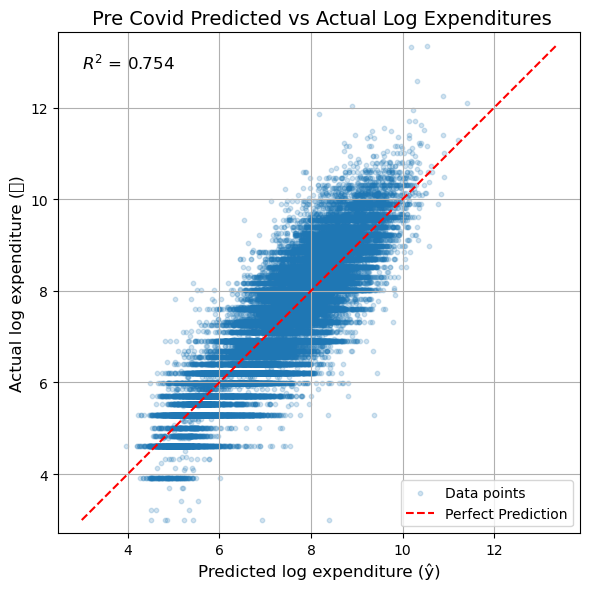

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})

# Drop any NaNs
df = df.dropna()


# Basic scatter
plt.figure(figsize=(6, 6))
plt.scatter(df['yhat'], df['y'], alpha=0.2, s=10, label="Data points")

# 45-degree line
lims = [
    np.min([df.y.min(), df.yhat.min()]),
    np.max([df.y.max(), df.yhat.max()]),
]
plt.plot(lims, lims, 'r--', label='Perfect Prediction')

# R^2
r2 = r2_score(df['y'], df['yhat'])
plt.text(lims[0], lims[1] - 0.5, f"$R^2$ = {r2:.3f}", fontsize=12)

# Labels and formatting
plt.title(" Pre Covid Predicted vs Actual Log Expenditures", fontsize=14)
plt.xlabel("Predicted log expenditure (ŷ)", fontsize=12)
plt.ylabel("Actual log expenditure (𝑦)", fontsize=12)
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Parameters

##### (Relative) Income Elasticity


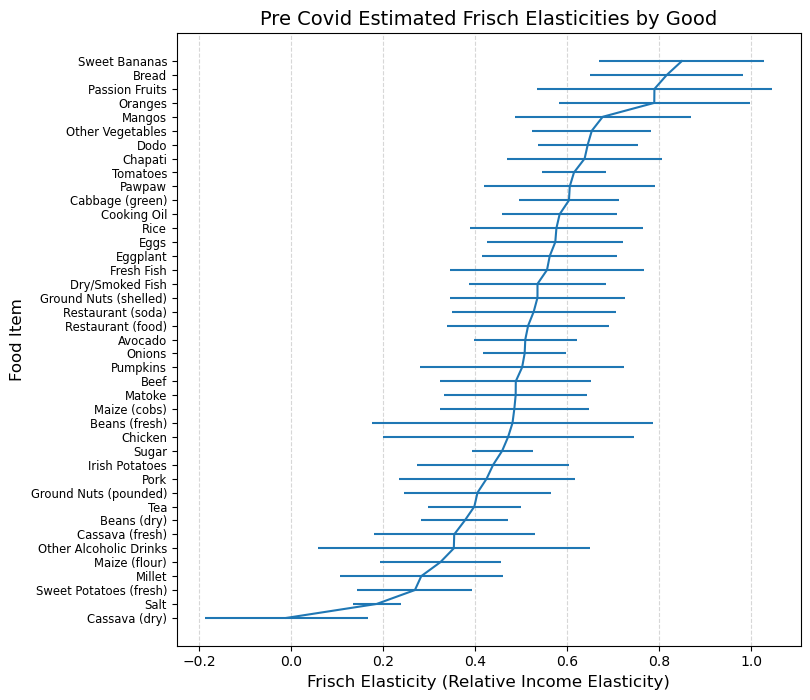

In [114]:
fig = result.graph_beta()
ax = fig.axes[0]  # get the first (and probably only) Axes object

# Now you can safely call axis methods:
ax.set_title("Pre Covid Estimated Frisch Elasticities by Good", fontsize=14)
ax.set_xlabel("Frisch Elasticity (Relative Income Elasticity)", fontsize=12)
ax.set_ylabel("Food Item", fontsize=12)
ax.grid(True, axis='x', linestyle='--', alpha=0.5)

In [115]:
result.get_beta()

j
Avocado                   0.508578
Beans (dry)               0.377119
Beans (fresh)             0.480744
Beef                      0.487941
Bread                     0.815905
Cabbage (green)           0.603504
Cassava (dry)            -0.010374
Cassava (fresh)           0.354109
Chapati                   0.637571
Chicken                   0.471200
Cooking Oil               0.583255
Dodo                      0.644315
Dry/Smoked Fish           0.535151
Eggplant                  0.561713
Eggs                      0.573781
Fresh Fish                0.555812
Ground Nuts (pounded)     0.404697
Ground Nuts (shelled)     0.535055
Irish Potatoes            0.438715
Maize (cobs)              0.484710
Maize (flour)             0.323857
Mangos                    0.676835
Matoke                    0.487663
Millet                    0.282458
Onions                    0.507194
Oranges                   0.788939
Other Alcoholic Drinks    0.353213
Other Vegetables          0.653205
Passion Fruits    

In [116]:
result.get_gamma()

k,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,
Avocado,-0.031445,0.093310,0.006800,0.014860,0.070582,-0.008020,0.044623,0.020619,0.031808,0.104070,0.041321,0.094634,0.079357,0.166555,0.255408,7.079546
Beans (dry),-0.031379,0.021955,0.052975,0.057628,0.023493,0.045694,0.144830,-0.053535,0.022700,0.088939,0.058550,0.061597,0.066560,0.106197,0.338030,8.078122
Beans (fresh),0.031392,-0.073437,0.012101,0.022890,-0.037254,0.068547,0.157540,0.009783,-0.024081,-0.030682,0.015225,-0.046685,0.040196,0.174321,0.570787,8.095554
Beef,-0.062833,-0.002699,0.001705,0.031014,0.077861,0.081237,0.052536,-0.056511,-0.004040,0.010277,0.029429,0.089044,0.117876,0.115129,0.294870,8.946762
Bread,-0.190372,-0.058995,0.033830,0.097431,0.199601,0.062781,0.138939,-0.029235,-0.006607,0.026080,0.029424,0.113119,0.192222,0.106509,0.294499,7.808949
Cabbage (green),0.000171,0.031339,0.049932,0.083971,0.115618,0.079166,0.033909,-0.002585,0.030868,0.080999,0.034951,0.089917,0.059209,0.151360,0.005829,6.977671
Cassava (dry),0.186960,0.038982,-0.028017,0.100503,-0.029845,0.114273,0.145024,0.073489,0.130592,0.040438,0.116710,0.028326,0.078746,0.038644,0.217919,8.218561
Cassava (fresh),-0.041487,0.044140,0.044395,0.039425,-0.050713,-0.046123,0.078037,-0.016806,0.039018,0.121333,0.049851,0.042454,-0.036394,0.041581,0.441755,7.894250
Chapati,-0.017537,-0.036392,-0.009340,0.150456,0.133973,0.151564,-0.024096,-0.017264,0.028236,0.004780,-0.003622,0.145853,0.221264,0.038499,0.029764,7.548830


##### Welfare


<Axes: ylabel='Density'>

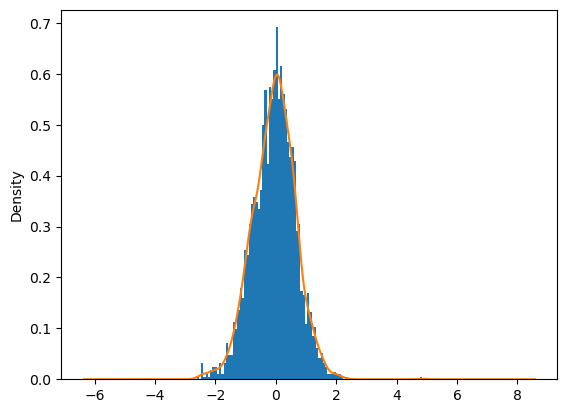

In [117]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result

In [118]:
result.to_pickle('uganda_estimates.rgsn')

In [119]:
import cfe
result = cfe.regression.read_pickle('uganda_estimates.rgsn')


#### Demand and Utility


##### Budgets


In [120]:
xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices


In [121]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
common_goods = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_goods].fillna(1)
#pbar = p.mean(axis=0)
pbar = pbar.reindex(result.beta.index, fill_value=1)
 # Only use prices for goods we can estimate

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [122]:
# 1) Average prices by rows => Series indexed by food names
pbar = p.mean(axis=0)

# 2) Debug: Check indices
print("pbar index:", pbar.index)
print("beta index:", result.beta.index)

# 3) Align
common_goods = pbar.index.intersection(result.beta.index)
print("Missing in prices:", set(result.beta.index) - set(common_goods))

pbar = pbar.loc[common_goods].fillna(1)

def my_prices(p0, j, p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p


pbar index: Index(['Beans', 'Beef', 'Beer', 'Biscuits', 'Bongo', 'Bread', 'Butter, etc.',
       'Cabbages', 'Cake', 'Cassava', 'Cassava (flour)', 'Chapati', 'Cheese',
       'Chicken', 'Cigarettes', 'Coffee', 'Cooking Oil', 'Cornflakes', 'Dodo',
       'Donut', 'Eggs', 'Fish (dried)', 'Fish (fresh)', 'Garlic', 'Ghee',
       'Ginger', 'Goat', 'Ground Nuts', 'Honey', 'Ice Cream', 'Infant Formula',
       'Irish Potatoes', 'Jackfruit', 'Jam/Marmalade', 'Kabalagala',
       'Macaroni/Spaghetti', 'Maize', 'Mangos', 'Matoke', 'Milk (fresh)',
       'Milk (powdered)', 'Millet', 'Onions', 'Oranges', 'Other Alcohol',
       'Other Drinks', 'Other Fruits', 'Other Juice', 'Other Meat',
       'Other Spices', 'Other Tobacco', 'Other Veg.', 'Passion Fruits', 'Peas',
       'Plantains', 'Pork', 'Rice', 'Salt', 'Samosa', 'Sim Sim', 'Soda',
       'Sorghum', 'Soybean', 'Sugar', 'Sugarcane', 'Sweet Bananas',
       'Sweet Potatoes', 'Tea', 'Tomatoes', 'Waragi', 'Water', 'Wheat (flour)',
       'Yam',

In [123]:
common_goods = pbar.index.intersection(result.beta.index)
print("Final goods in pbar:", len(common_goods))
print("Expected goods in result:", len(result.beta.index))

Final goods in pbar: 21
Expected goods in result: 41


In [124]:
common_goods = pbar.index.intersection(result.beta.index)
print("Final goods in pbar:", len(common_goods))
print("Expected goods in result:", len(result.beta.index))

missing = set(result.beta.index) - set(common_goods)
print("Missing goods:", missing)

Final goods in pbar: 21
Expected goods in result: 41
Missing goods: {'Dry/Smoked Fish', 'Maize (cobs)', 'Ground Nuts (shelled)', 'Eggplant', 'Beans (fresh)', 'Cassava (fresh)', 'Ground Nuts (pounded)', 'Cabbage (green)', 'Beans (dry)', 'Maize (flour)', 'Avocado', 'Pawpaw', 'Sweet Potatoes (fresh)', 'Restaurant (food)', 'Fresh Fish', 'Cassava (dry)', 'Restaurant (soda)', 'Other Vegetables', 'Pumpkins', 'Other Alcoholic Drinks'}


##### Demand as a function of prices


/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarnin

Text(0.5, 0, 'Quantities of Beef Demanded')

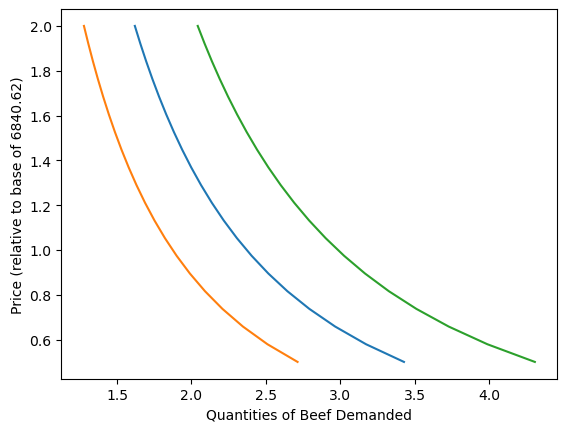

In [125]:
# Ensure pbar is aligned and complete
pbar = pbar.reindex(result.beta.index, fill_value=1)

use = 'Beef'
scale = np.linspace(.5, 2, 20)

# Helper function to safely compute demands
def get_demand(x, good, scale_factor):
    p_scaled = my_prices(pbar[good] * scale_factor, good, pbar)
    demand = result.demands(x, p_scaled)
    return demand[good]

plt.plot([get_demand(xref, use, s) for s in scale], scale)
plt.plot([get_demand(xbar.quantile(0.25), use, s) for s in scale], scale)
plt.plot([get_demand(xbar.quantile(0.75), use, s) for s in scale], scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")


/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarnin

Text(0.5, 0, 'Quantities of Beef Demanded')

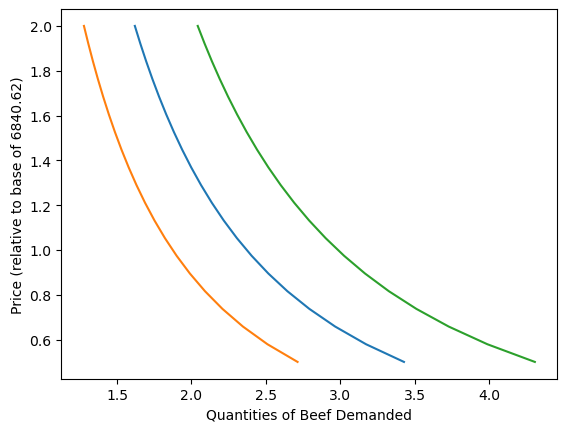

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Beef'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves


/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarnin

Text(0.5, 1.0, 'Engel Curves')

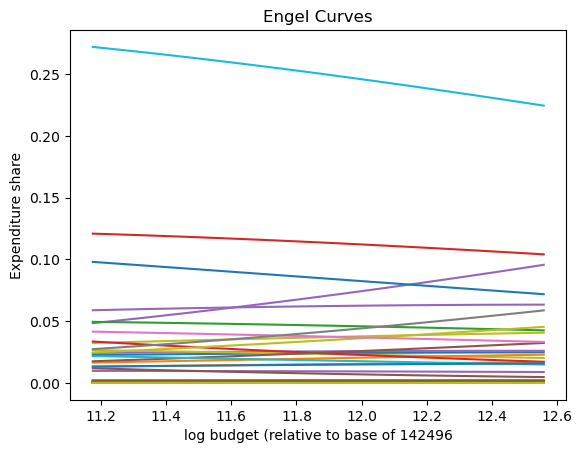

In [127]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility


/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/srv/conda/lib/python3.11/site-packages/consumerdemands/_utils.py:54: UserWarnin

Text(0.5, 1.0, 'Indirect Utility Function')

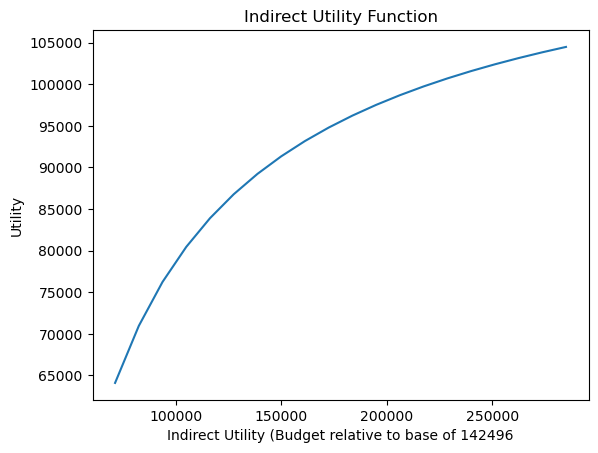

In [128]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# [C] Counterfactual Experiments

In [129]:
print("y_2 type:", type(x_2.stack()))
print("z_2 type:", type(z_2))
print("y_2 index names:", x_2.stack().index.names)
print("z_2 index names:", z_2.index.names)

NameError: name 'x_2' is not defined

In [ ]:
import cfe

result = cfe.Regression(y=np.log(x_2.stack()),d=z_2)

result.get_beta().sort_values(ascending=False)
